# Крайников РТ5-61Б НИРС


## 1. Выбор и подготовка набора данных

In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from scipy.stats import randint
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV


В качестве набора данных будем использовать набор данных, состоящий из данных о местных видах растений Нью-Джерси (https://www.kaggle.com/datasets/msjahid/native-plant-species-of-new-jersey)

In [192]:
train_data = pd.read_csv('New_Jersey_native_plants.csv')
train_data = train_data.filter(
    ["Family","Scientific Name","Common Name","Duration","Habit","Light","Soil Moisture","Height","Color","Bloom Period"]
)
train_data.head()

,Family,Scientific Name,Common Name,Duration,Habit,Light,Soil Moisture,Height,Color,Bloom Period
0,Sapindaceae,Acer rubrum,Red Maple,Deciduous,Tree,Sun - Part Shade,Any,40' - 60',Red,March - April
1,Sapindaceae,Acer saccharinum,Silver Maple,Deciduous,Tree,Sun - Part Shade,Wet,80' - 115',Green and Yellow,April - May
2,Sapindaceae,Acer saccharum,Sugar Maple,Deciduous,Tree,Part Sun,Medium,80' - 120',Greenish Yellow,April - June
3,Liliacea,Alisma subcordatum,American Water Plantain,Perennial,Herb,Sun,Wet,1' - 3',White to Pinkish,June - September
4,Liliacea,Allium cernuum,Nodding Onion,Perennial,Herb,Sun,Medium,1' - 3',Pink,June - August


In [193]:
train_data.shape

(170, 10)

Итоговый набор содержит следующие колонки:

* Family: Таксономическая семья растительного вида.
* Scientific Name: Научное название вида растений.
* Common Name: Общее название вида растений.
* Duration: Продолжительность жизни растения (например, многолетнее, ежегодное).
* Habit: Способ роста растения (например, дерево, куст, трава).
* Light: Требования к освещению для оптимального роста (например, полное солнце, частичная тень).
* Soil Moisture: Предпочтительный уровень влажности почвы для растения.
* Height: Типичный диапазон высоты растения.
* Color: Цвет цветов или листвы растения.
* Bloom Period: Период, в течение которого растение обычно цветет.

# 2. Разведочный анализ

Проверим пропуски

In [194]:
train_data.isnull().sum()

Family              0
Scientific Name     0
Common Name         0
Duration            0
Habit               0
Light               0
Soil Moisture       0
Height              0
Color              11
Bloom Period        6
dtype: int64

Как видим, есть пропуски в колонках Color, Bloom Period.

In [195]:
train_data.dropna(inplace=True)
train_data.isnull().sum()

Family             0
Scientific Name    0
Common Name        0
Duration           0
Habit              0
Light              0
Soil Moisture      0
Height             0
Color              0
Bloom Period       0
dtype: int64

In [196]:
train_data.head()

,Family,Scientific Name,Common Name,Duration,Habit,Light,Soil Moisture,Height,Color,Bloom Period
0,Sapindaceae,Acer rubrum,Red Maple,Deciduous,Tree,Sun - Part Shade,Any,40' - 60',Red,March - April
1,Sapindaceae,Acer saccharinum,Silver Maple,Deciduous,Tree,Sun - Part Shade,Wet,80' - 115',Green and Yellow,April - May
2,Sapindaceae,Acer saccharum,Sugar Maple,Deciduous,Tree,Part Sun,Medium,80' - 120',Greenish Yellow,April - June
3,Liliacea,Alisma subcordatum,American Water Plantain,Perennial,Herb,Sun,Wet,1' - 3',White to Pinkish,June - September
4,Liliacea,Allium cernuum,Nodding Onion,Perennial,Herb,Sun,Medium,1' - 3',Pink,June - August


Количество продолжительностей жизни растения:

In [197]:
train_data['Duration'].nunique()

7

Количество данных по каждому продолжительности жизни растения

In [198]:
train_data.groupby('Duration').size().sort_values().unique

<bound method Series.unique of Duration
Annual, Biennial, Perennial      1
Annual, Perennial                1
Biennial, Perennial              1
Broadleaf Evergreen              1
Evergreen                        5
Deciduous                       50
Perennial                      100
dtype: int64>

Для решения задачи классификации выберем две продолжительности жизни: Deciduous и Perennial (Листопадные и многолетние растения)

In [199]:
durations = ['Deciduous', 'Perennial']

train_data = train_data[train_data['Duration'].isin(durations)]
train_data['Duration'].unique()

array(['Deciduous', 'Perennial'], dtype=object)

Проверим размер набора данных

In [200]:
train_data.shape

(150, 10)

Подсчитаем количество цветов

In [201]:
train_data['Color'].nunique()

47

Выведем преобладающие цвета по каждому из продолжительности

In [202]:
for l in durations:
    print(l + ':')
    print(train_data[train_data['Duration']==l]['Color'].value_counts().head(5))
    print('\n')

Deciduous:
Color
White                   12
Yellow                   8
Yellow, green, brown     3
Greenish Yellow          3
Pink                     2
Name: count, dtype: int64


Perennial:
Color
Yellow    20
Green     20
White     14
Purple     9
Red        3
Name: count, dtype: int64




Для понимания структуры набора данных построим графики, но для начала закодируем категориальные признаки:

In [203]:
# Создание копии исходного датасета
train_data_encoded = train_data.copy()

# Создание объекта LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к каждому категориальному столбцу
for column in train_data_encoded.columns:
    if train_data_encoded[column].dtype == 'object':
        train_data_encoded[column] = label_encoder.fit_transform(train_data_encoded[column])

# Вывод первых нескольких строк преобразованного датасета
train_data_encoded.head()

,Family,Scientific Name,Common Name,Duration,Habit,Light,Soil Moisture,Height,Color,Bloom Period
0,47,0,94,0,4,8,0,53,21,21
1,47,1,108,0,4,8,6,82,9,4
2,47,2,119,0,4,5,3,83,13,3
3,29,3,4,1,1,7,6,4,32,19
4,29,4,78,1,1,7,3,4,16,16


Для понимания структры набора данных построим графики:

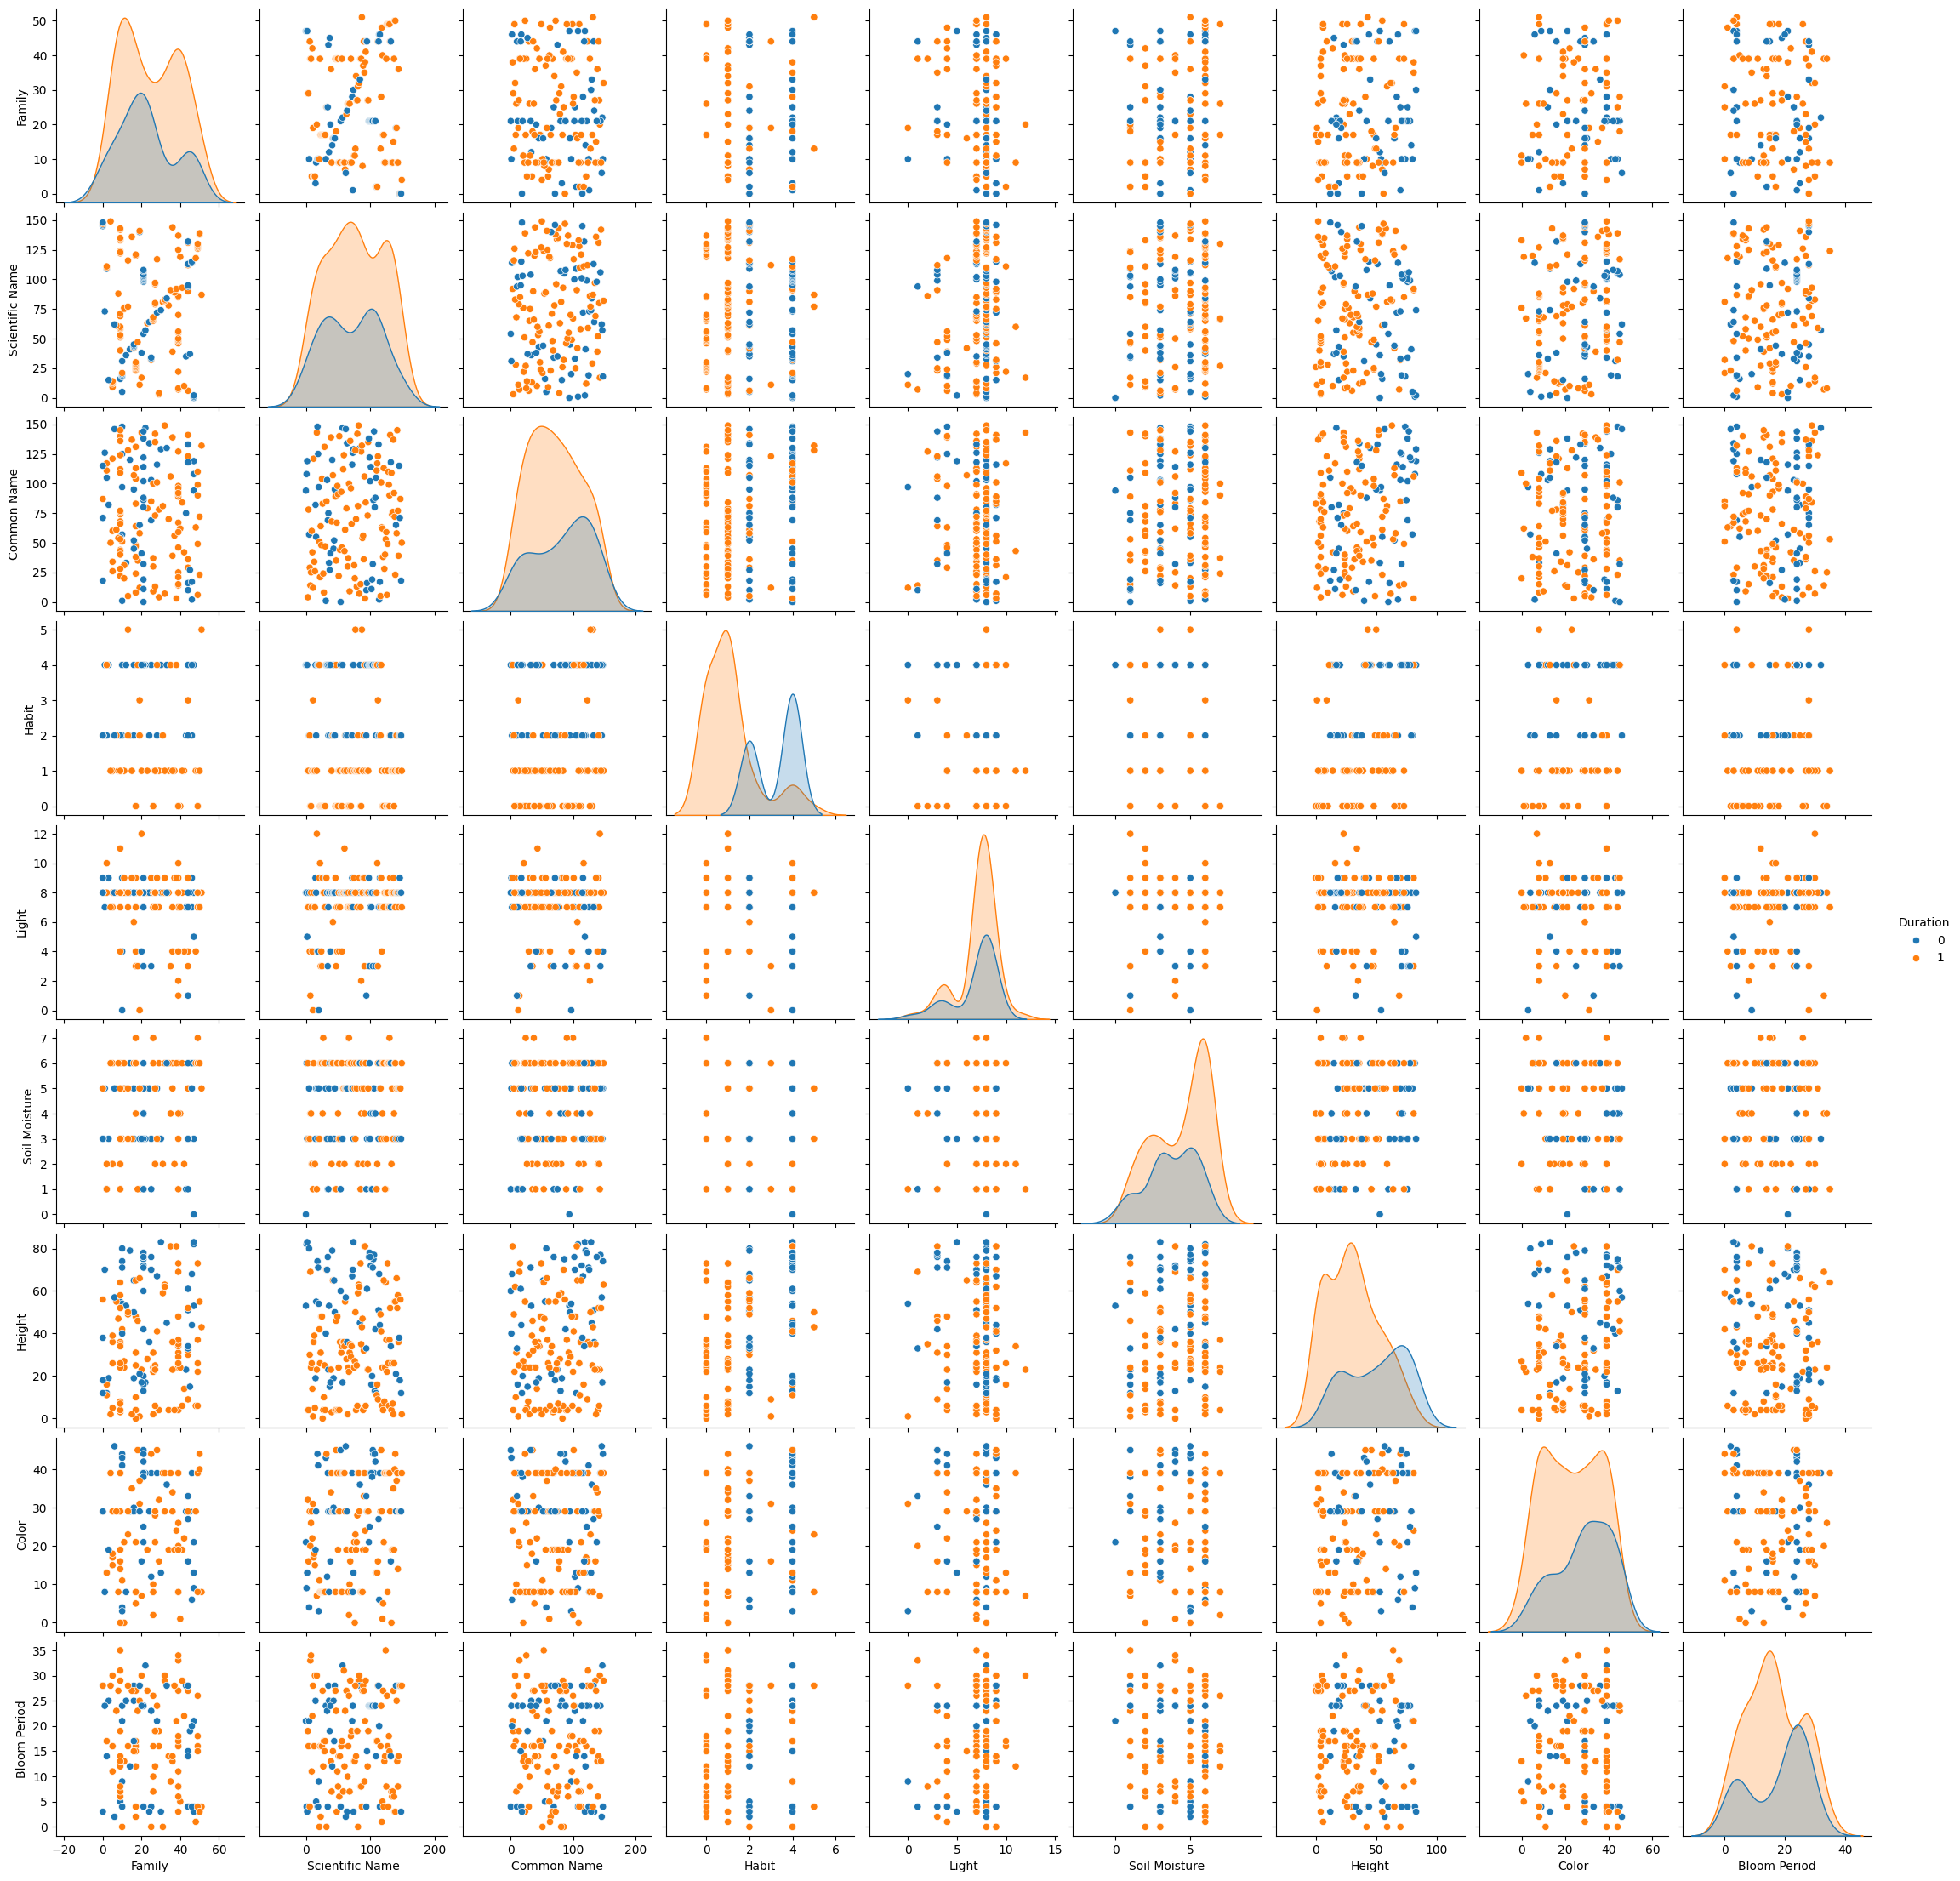

In [204]:
sns.pairplot(train_data_encoded, hue='Duration')

Количество наименований семейств для каждой продолжительности:

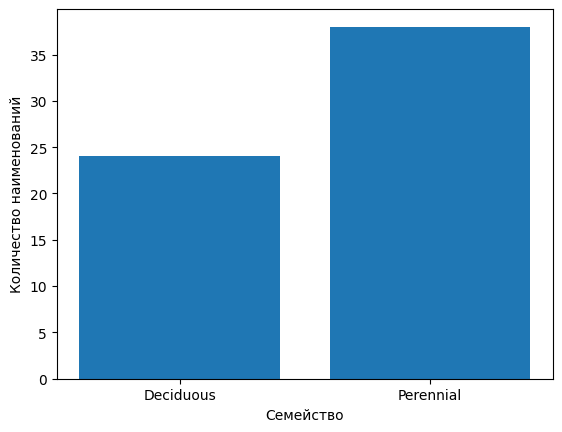

In [234]:
x_durations = np.arange(len(durations))
y_names = train_data.groupby('Duration')['Family'].nunique()

plt.bar(x_durations, y_names)
plt.xticks(x_durations, durations)
plt.xlabel('Семейство')
plt.ylabel('Количество наименований')
plt.show()

Самые частые периоды цветения

<Axes: ylabel='Bloom Period'>

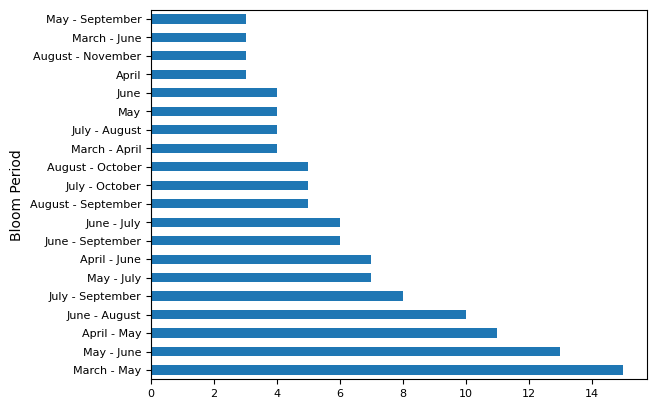

In [206]:
train_data['Bloom Period'].value_counts().head(20).plot(kind='barh', fontsize=8)

# 3. Корреляционный анализ данных

<Axes: title={'center': 'Heatmap корреляции'}>

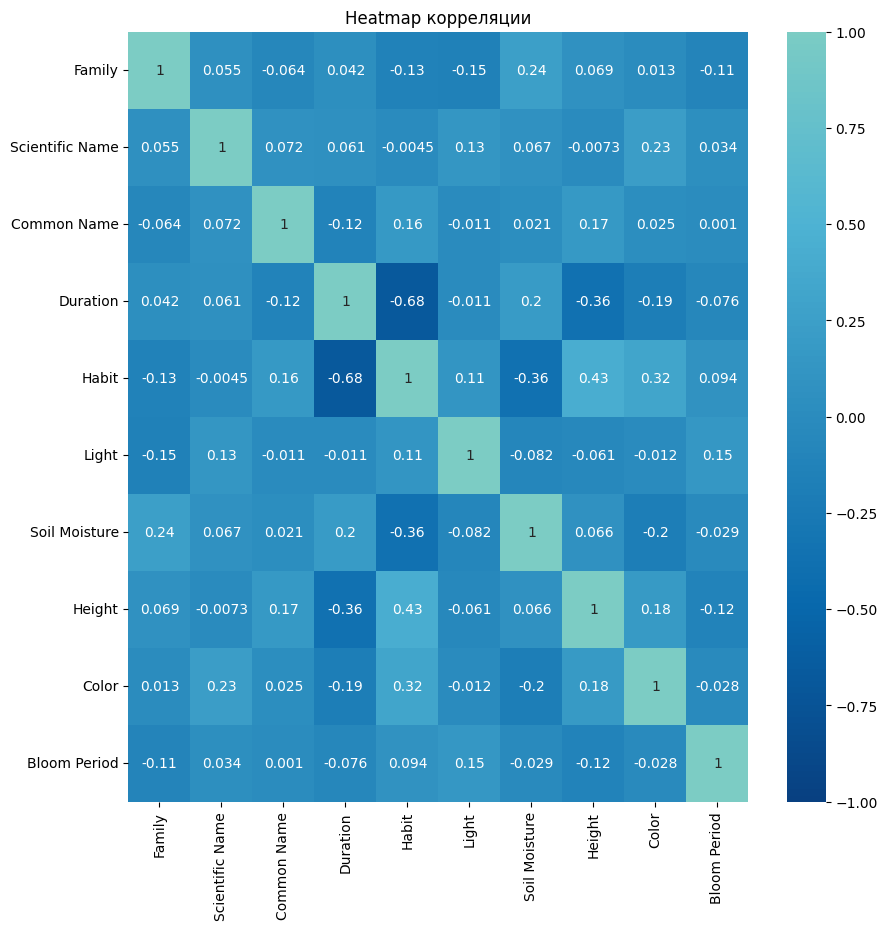

In [207]:
correlation = train_data_encoded.corr(method='spearman')
plt.figure(figsize=(10, 10))
plt.title('Heatmap корреляции')
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, cmap="GnBu_r", center=1)

Проверим связь между высотой и способом роста

<Axes: title={'center': 'Корреляция между высотой и способом роста'}, xlabel='Height', ylabel='Habit'>

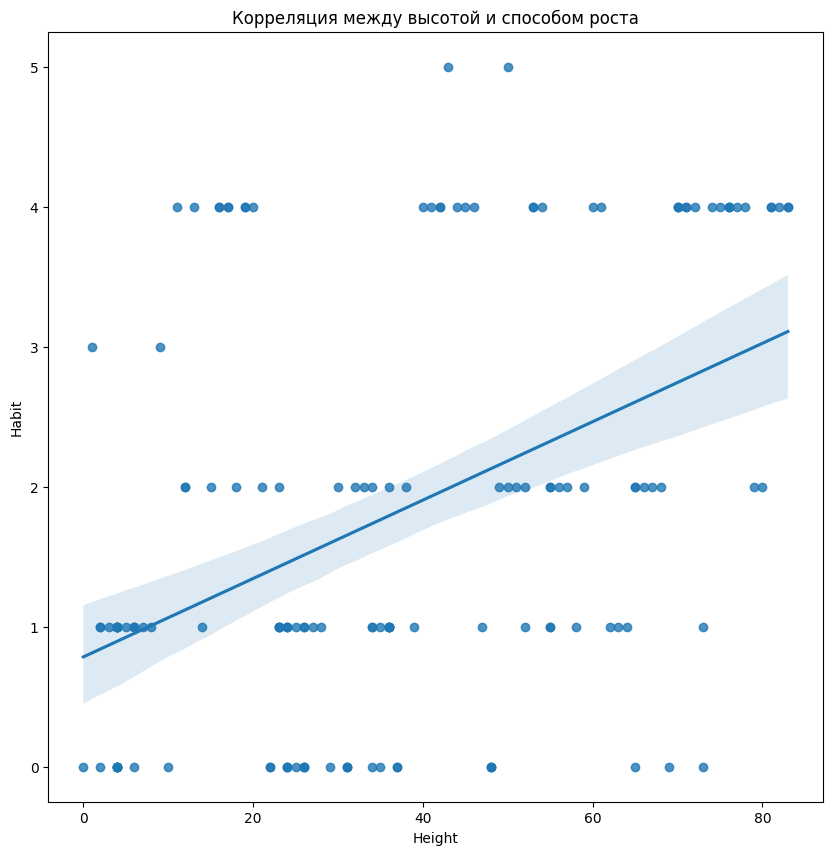

In [235]:
fig=plt.subplots(figsize=(10,10))
plt.title('Корреляция между высотой и способом роста')
sns.regplot(x='Height', y='Habit', data=train_data_encoded)

<Axes: title={'center': 'Корреляция между способом роста и цветом'}, xlabel='Habit', ylabel='Color'>

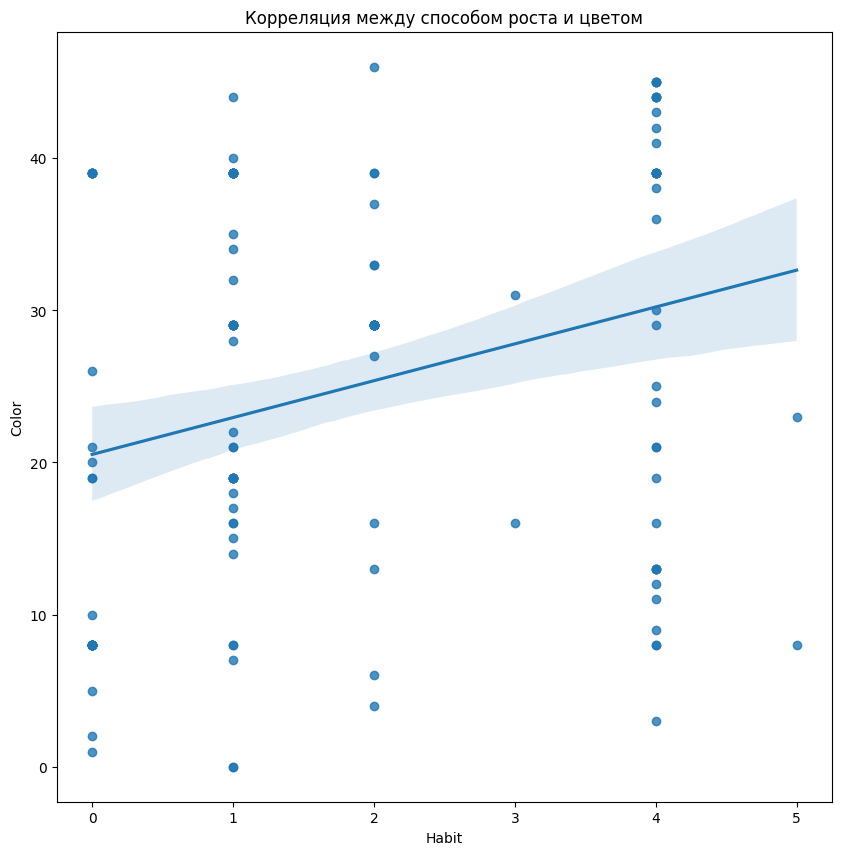

In [236]:
fig=plt.subplots(figsize=(10,10))
plt.title('Корреляция между способом роста и цветом')
sns.regplot(x='Habit', y='Color', data=train_data_encoded)

# 4. Метрики для оценки качества моделей

In [210]:
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc_value=roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area=%0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [211]:
class MetricLogger:
    def __init__(self):
        self.df = pd.DataFrame({'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})
        
    def add(self, metric, alg, value):
        self.df = self.df.drop(self.df[(self.df['metric'] == metric) & (self.df['alg'] == alg)].index)
        self.df.loc[len(self.df)] = [metric, alg, value]

    def get_data_for_metric(self, metric, ascending=True):
        temp_data = self.df[self.df['metric'] == metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5,5)):
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric, align='center', height=0.5, tick_label=array_labels)
        ax1.set_title(str_header)
        for a, b in zip(pos, array_metric):
            plt.text(0.5, a - 0.05, str(round(b,3)), color='white')
        plt.show()

In [212]:
metricLogger = MetricLogger()

In [213]:
def test_model(model_name, model, metricLogger):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test,y_pred)
    recall = recall_score(Y_test, y_pred)

    print('*' * 80)
    print(model)
    print('*' * 80)

    print('precision: ', precision)
    print('recall: ', recall)
    print('accuracy: ', accuracy)
    print('roc_auc: ', roc_auc)

    print('*' * 80)

    metricLogger.add('precision', model_name, precision)
    metricLogger.add('recall', model_name, recall)
    metricLogger.add('accuracy', model_name, accuracy)
    metricLogger.add('roc_auc', model_name, roc_auc)

    draw_roc_curve(Y_test, y_pred)

    plt.show()

# 5. Формирование обучающей и тестовой выборок

In [214]:
train_data_encoded.head()

,Family,Scientific Name,Common Name,Duration,Habit,Light,Soil Moisture,Height,Color,Bloom Period
0,47,0,94,0,4,8,0,53,21,21
1,47,1,108,0,4,8,6,82,9,4
2,47,2,119,0,4,5,3,83,13,3
3,29,3,4,1,1,7,6,4,32,19
4,29,4,78,1,1,7,3,4,16,16


Разделим выборки:

In [215]:
X = train_data_encoded.drop('Duration', axis=1)
Y = train_data_encoded['Duration']

In [216]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(112, 9), (38, 9)
(112,), (38,)


# 6. Построение базового решения

In [217]:
models = {'KNN_3': KNeighborsClassifier(n_neighbors=3),
        'SVC': SVC(),
        'Tree': DecisionTreeClassifier(),
        'RF': RandomForestClassifier(),
        'GB': GradientBoostingClassifier()}

********************************************************************************
KNeighborsClassifier(n_neighbors=3)
********************************************************************************
precision:  0.5
recall:  0.7368421052631579
accuracy:  0.5
roc_auc:  0.5
********************************************************************************


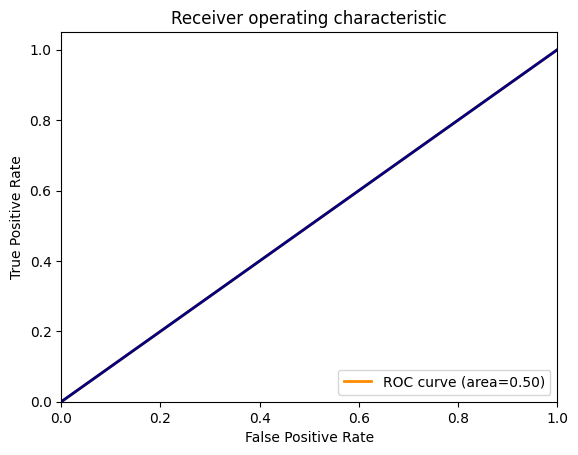

********************************************************************************
SVC()
********************************************************************************
precision:  0.5277777777777778
recall:  1.0
accuracy:  0.5526315789473685
roc_auc:  0.5526315789473684
********************************************************************************


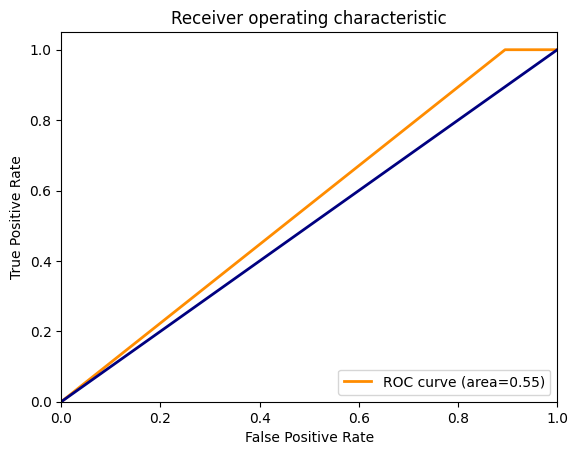

********************************************************************************
DecisionTreeClassifier()
********************************************************************************
precision:  0.8888888888888888
recall:  0.8421052631578947
accuracy:  0.868421052631579
roc_auc:  0.868421052631579
********************************************************************************


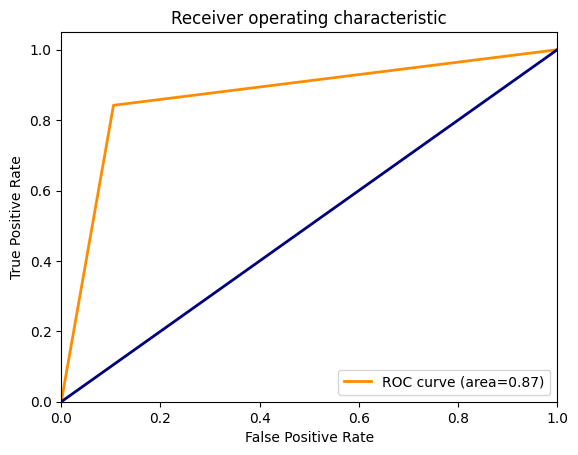

********************************************************************************
RandomForestClassifier()
********************************************************************************
precision:  0.8
recall:  0.8421052631578947
accuracy:  0.8157894736842105
roc_auc:  0.8157894736842104
********************************************************************************


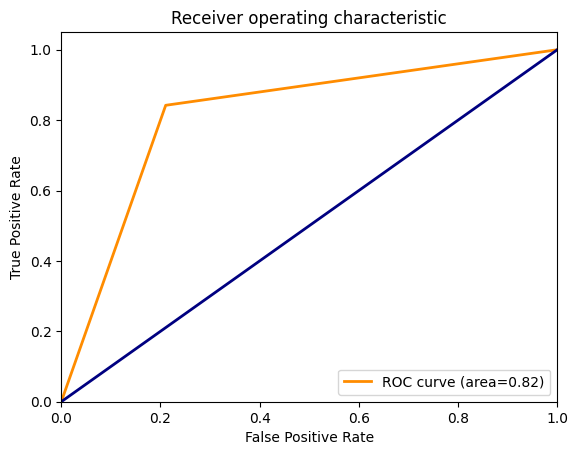

********************************************************************************
GradientBoostingClassifier()
********************************************************************************
precision:  0.8
recall:  0.8421052631578947
accuracy:  0.8157894736842105
roc_auc:  0.8157894736842104
********************************************************************************


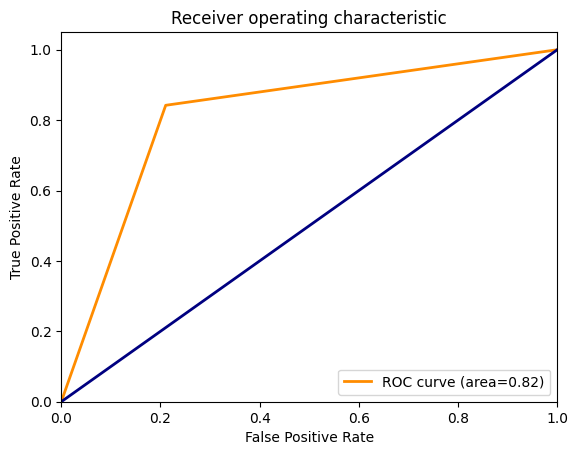

In [218]:
for model_name, model in models.items():
    test_model(model_name, model, metricLogger)

# 7. Подбор гипер-параметров

In [219]:
X_train.shape

(112, 9)

### Дерево решений

In [220]:
%%time
tree_parameters = {'max_depth': randint(1, 100)}
clf_gs = RandomizedSearchCV(DecisionTreeClassifier(), tree_parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
clf_gs.fit(X,Y)

CPU times: user 99.4 ms, sys: 200 ms, total: 300 ms
Wall time: 1.41 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f47a4c36fc0>},
                   scoring='accuracy')

In [221]:
clf_gs.best_estimator_

DecisionTreeClassifier(max_depth=7)

Лучшее значение параметров:

In [222]:
clf_gs.best_params_

{'max_depth': 7}

Средний результат

In [223]:
clf_gs.cv_results_['mean_test_score']

array([0.74666667, 0.74      , 0.80666667, 0.74666667, 0.77333333,
       0.77333333, 0.75333333, 0.74666667, 0.75333333, 0.75333333])

### Градиентный бустинг

In [224]:
param_dist = {'learning_rate': [1e-3, 1e-2, 1e-1], 
              'subsample': np.linspace(1e-3, 0.9, 10),
              'n_estimators': randint(1, 100), 
              'max_depth': randint(1, 10)}

gb = GradientBoostingRegressor()

random_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=100)
random_search.fit(X_train, Y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4738e8f590>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f47a5c73ec0>,
                                        'subsample': array([0.001     , 0.10088889, 0.20077778, 0.30066667, 0.40055556,
       0.50044444, 0.60033333, 0.70022222, 0.80011111, 0.9       ])})

In [225]:
random_search.best_estimator_

GradientBoostingRegressor(max_depth=1, n_estimators=31,
                          subsample=0.8001111111111111)

Лучшие значения параметров

In [226]:
random_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 31,
 'subsample': 0.8001111111111111}

Средний результат:

In [227]:
random_search.cv_results_['mean_test_score']

array([ 2.45247545e-01,  8.72990777e-02,  2.07602384e-02,  1.24709597e-02,
        1.89603348e-01, -2.53941134e-02, -2.13140201e-02,  2.12255510e-01,
        2.75975252e-01,  2.03752142e-01,  2.40731067e-01,  2.59498839e-02,
        2.93905517e-01,  2.20828132e-01,  1.28111747e-01,  2.23813298e-04,
        1.82069746e-01,  2.95112223e-02,  7.23296989e-02, -4.94312045e-02,
       -1.75941876e-02,  2.63221923e-01, -4.57402765e-02, -3.09786616e-02,
        1.10383435e-02,  1.23968604e-01,  2.56832250e-01, -3.34173154e-02,
        1.39263532e-01, -3.72371573e-02,  1.33871498e-03,  2.53216544e-01,
       -3.10407588e-04, -2.44315720e-02,  1.59761361e-02,  3.48363055e-01,
        7.69158490e-03,  1.20303812e-01,  1.75738988e-02, -5.65960904e-02,
        2.45433998e-01, -5.78420808e-03,  2.23721206e-01,  9.13090674e-02,
       -3.75736143e-02,  1.46870155e-01,  1.99847871e-01,  4.66728013e-03,
       -1.79355900e-02,  2.83499476e-01,  2.16105858e-01, -2.59729378e-02,
       -1.15443432e-02,  

# 8. Сравнение качества полученных моделей с качеством baseline-моделей

### Дерево решений

********************************************************************************
DecisionTreeClassifier()
********************************************************************************
precision:  0.8888888888888888
recall:  0.8421052631578947
accuracy:  0.868421052631579
roc_auc:  0.868421052631579
********************************************************************************


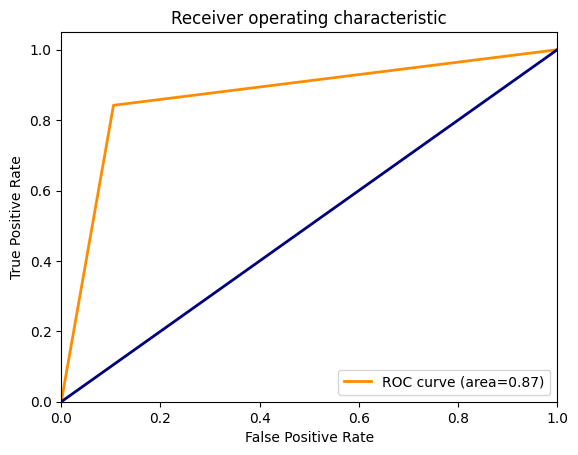

In [228]:
test_model('Tree', DecisionTreeClassifier(), metricLogger)

********************************************************************************
RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f47a4c36fc0>},
                   scoring='accuracy')
********************************************************************************
precision:  0.8888888888888888
recall:  0.8421052631578947
accuracy:  0.868421052631579
roc_auc:  0.868421052631579
********************************************************************************


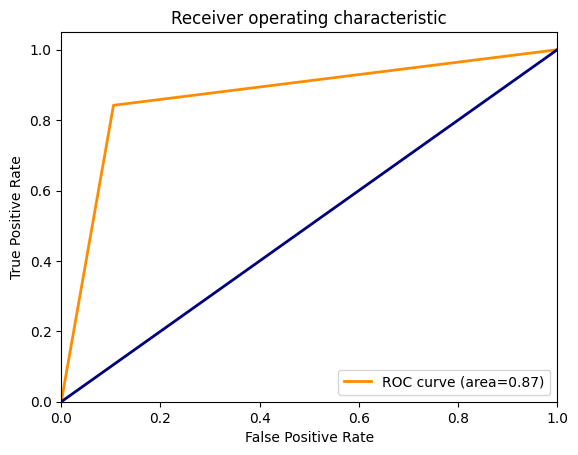

In [229]:
test_model('Tree_tuned', RandomizedSearchCV(DecisionTreeClassifier(), tree_parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10), metricLogger)

### Градиентный бустинг

********************************************************************************
GradientBoostingClassifier()
********************************************************************************
precision:  0.8
recall:  0.8421052631578947
accuracy:  0.8157894736842105
roc_auc:  0.8157894736842104
********************************************************************************


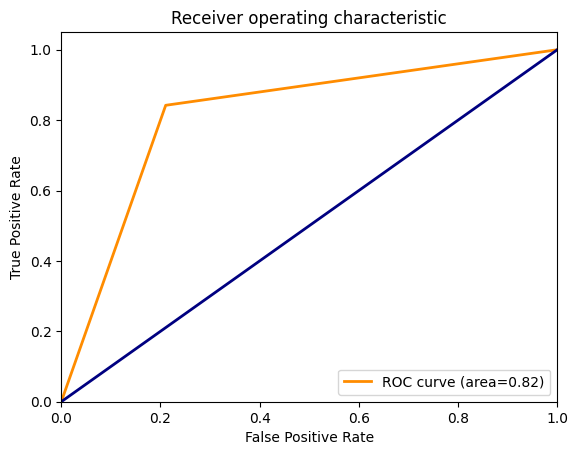

In [230]:
test_model('GB', GradientBoostingClassifier(), metricLogger)

********************************************************************************
RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4738e8f590>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f47a5c73ec0>,
                                        'subsample': array([0.001     , 0.10088889, 0.20077778, 0.30066667, 0.40055556,
       0.50044444, 0.60033333, 0.70022222, 0.80011111, 0.9       ])},
                   scoring='accuracy')
********************************************************************************
precision:  0.8
recall:  0.8421052631578947
accuracy:  0.8157894736842105
roc_auc:  0.8157894736842104
********************************************************************************


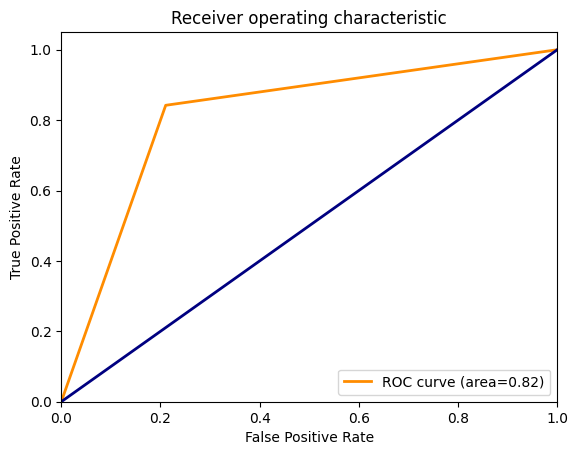

In [231]:
test_model('GB_tuned', RandomizedSearchCV(GradientBoostingClassifier(), param_dist, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10), metricLogger)

# 9. Выводы о качестве построенных моделей


In [232]:
metrics = ['precision', 'recall', 'accuracy', 'roc_auc']
metrics

['precision', 'recall', 'accuracy', 'roc_auc']

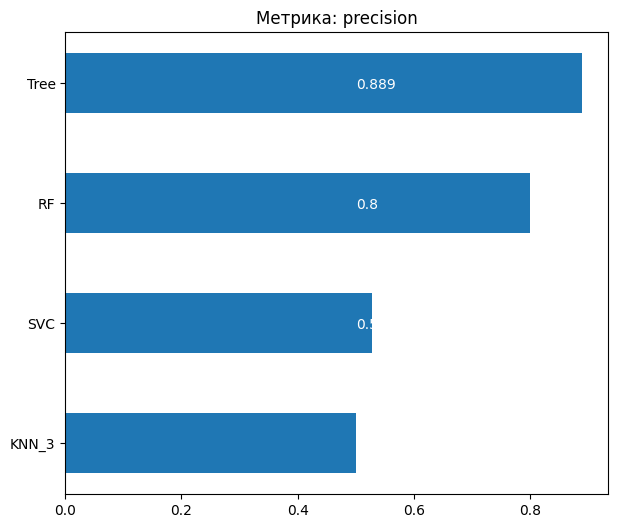

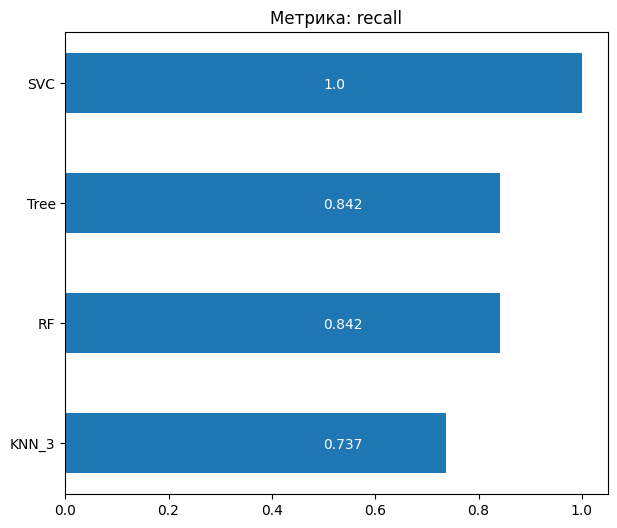

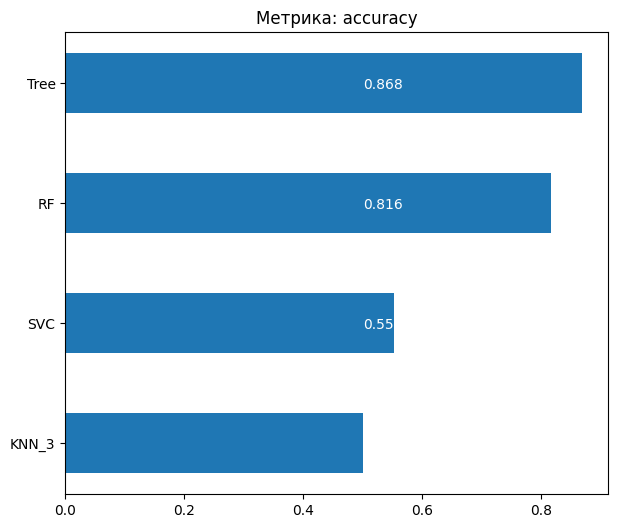

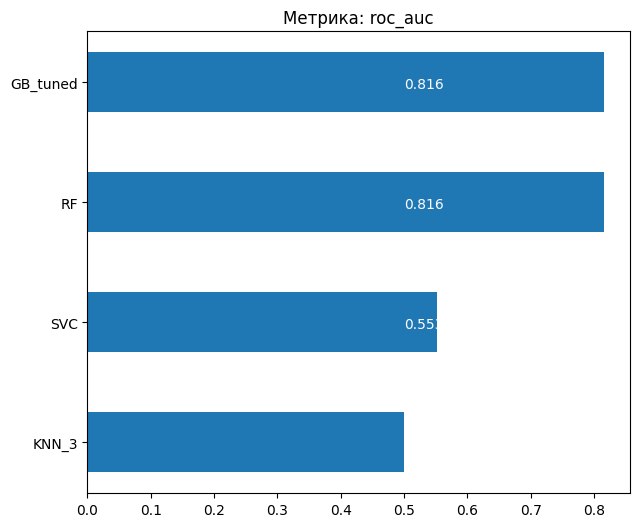

In [233]:
for metric in metrics:
    metricLogger.plot('Метрика: ' + metric, metric, figsize=(7,6))

# Вывод

Было использовано 5 моделей, для двух из них был проведен подбор гиперпараметров - дерево решений и градиентный бустинг. Лучше всего показали себя модели: метод случайного леса и дерево решений. Худший результат показали модели KNN и SVC с точностью в 0.5. В результате подбора гиперпараметров изменения остались незначительными.

# Заключение

В данном НИРе мы выполнили типовую задачу машинного обучения. Провели анализ данных, преобразовали готовый датасет под наши потребности, подобрали модели, а также подобрали наиболее подходящие гиперпараметры.

В нашем случае классификатор на модели случайного леса показал наилучший результат. В ходе подбора гиперпараметров результаты оказались приблизительно одинаковыми.

В данном проекте были закреплены все знания, полученные в курсе лекций и на лабораторных работах. Часть информации была найдена в различных открытых источниках в интернете.
